# MNIST

Obiettivo: costruire un modello che sia in grado di riconoscere carattere numerico manoscritto.

paragonare modello dl senza preprocessing e modello costruito dopo preprocessing

## Step

Al fine di diminuire il numero di neuroni della rete e migliorare le prestazioni, si effettua del preprocessing.

- Importing data
- Preprocessing
  1. eliminazione rumore (filtro mediano)
  1. uniforming thickness
  1. resizing & centering
  1. fixing discontinuity (reconstructing ink hole)
  1. normalizing
- model

Cominciamo importando le librerie necessarie per il corretto funzionamento del codice (tensorflow, keras, matplotlib)

In [1]:
import cv2
import tensorflow.keras as keras
import tensorflow as tf
import mnist
import numpy as np
import matplotlib.pyplot as plt
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Dense

2023-03-24 16:32:36.653346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 16:33:03.341173: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dennisangemi/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-24 16:33:03.341226: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-24 16:33:31.880978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

In [2]:
# loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path = "mnist.npz")

# undestand data dimensions
print("Data dimensions:\n")
print("x_lrn:",x_train.shape)
print("x_tst:",x_test.shape)
print("y_lrn:",y_train.shape)
print("y_tst:",y_test.shape)

Data dimensions:

x_lrn: (60000, 28, 28)
x_tst: (10000, 28, 28)
y_lrn: (60000,)
y_tst: (10000,)


Visualizziamo un'immagine del dataset di learning (per modificare il numero dell'immagine, modifica il valore della variabile `npat`)

Ecco il pattern n. 7
Il valore atteso è:  3


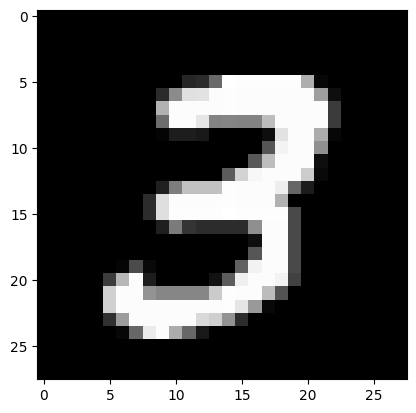

In [3]:
npat = 7
print("Ecco il pattern n.", npat)
print("Il valore atteso è: ", y_train[npat]);

image = x_train[npat];
plt.imshow(image, cmap = 'gray')
plt.show(block = False)

Da adesso in poi useremo una variabile temporanea `img` che conterrà l'immagine `x_train[npat]` in modo tale da non lavorare con l'intero array di immagini.

In [22]:
img = x_train[npat]

## Reducing noise

L'idea è quella di applicare un filtro mediano.

Utilizzeremo la libreria `OpenCV` (che importeremo con `import cv2`) dopo averla installata da terminale `pip install opencv-python`

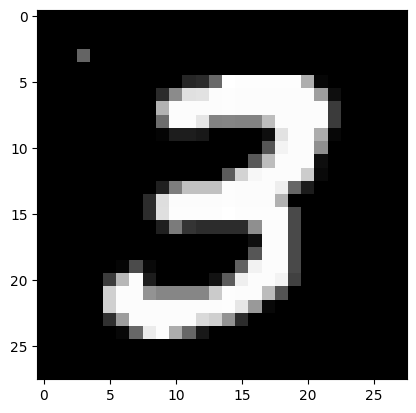

In [23]:
# add noise in pixel 3,3
img[3,3] = 100

# show img
plt.imshow(img, cmap = 'gray')
plt.show()

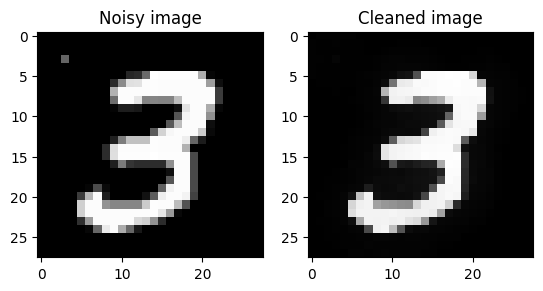

In [24]:
# using csv2 to remove noise
# x_train = cv2.medianBlur(x_train, 1)

# bisognerebbe fare un for ma l'operazioe sembra molto lenta
# denoised = cv2.fastNlMeansDenoising(x_train[npat], h=60, templateWindowSize=3, searchWindowSize=8)
# denoised = cv2.GaussianBlur(x_train[npat], (3, 3), 1)
denoised = cv2.bilateralFilter(img, 9, 70, 70)

# plotting
plt.subplot(1,2,1)
plt.title("Noisy image")
plt.imshow(img, cmap = 'gray')
plt.subplot(1,2,2)
plt.title("Cleaned image")
plt.imshow(denoised, cmap = 'gray')
plt.show()

In [25]:
denoised[3,3]

5

## Binarizing

Al fine di uniformare lo spessore dei caratteri, sembrerebbe necessario effettuare una binarization ovvero rendere "binari" i valori dei pixel (0 oppure 1).

Esistono varie tecniche ([vedi qui](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)) ma noi proveremo ad usare `cv2.ADAPTIVE_THRESH_GAUSSIAN_C`

```python
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
```

se non funzinoa, possiamo provare il metodo di Otzu:
```python
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
```

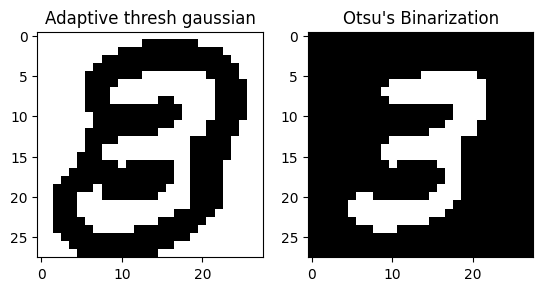

In [32]:
# adaptive thresh gaussian
atg = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,6)

# otsu
ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plotting results
plt.subplot(1,2,1)
plt.title("Adaptive thresh gaussian")
plt.imshow(atg, cmap = 'gray')
plt.subplot(1,2,2)
plt.title("Otsu's Binarization")
plt.imshow(ots, cmap = 'gray')
plt.show()

Continueremo utilizzando il metodo di Otsu

## Fix discontinuity

OpenCV's Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

`closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)`

dove 

`kernel = np.ones((5,5),np.uint8)`

è la dimensione della finestra di azione del filtro.

[Click here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) for more info

Si tratta essenzialmente di un `dilate` seguito da `erode` per "coprire i buchi"

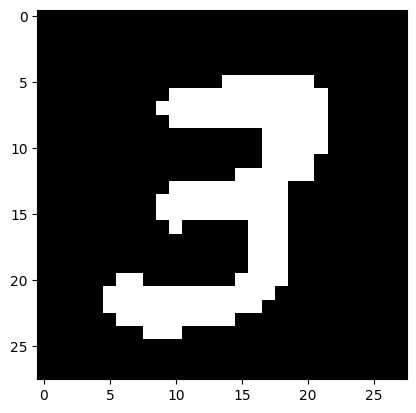

In [33]:
# pìxel lato finestra
w = 3

# creo finestra
kernel = np.ones((w,w),np.uint8)

# rimuovo buchi
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.imshow(img, cmap = 'gray')
plt.show()

## Uniformare thickness

- domanda senza risposta stackoverflow https://stackoverflow.com/questions/56601130/how-to-reduce-the-thickness-of-the-contours

- qui una risposta https://stackoverflow.com/questions/51133962/how-can-i-scale-a-thickness-of-a-character-in-image-using-python-opencv

Lo strumento vincente sembra erosion di OpenCV ([leggi qui](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#erosion))

La sintassi è:

```python
img = cv2.imread('j.png',0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
```

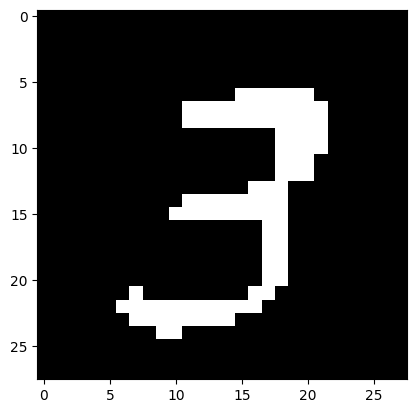

In [39]:
w = 2

# creo finestra
kernel = np.ones((w,w),np.uint8)

# riduco spessore
erosion = cv2.erode(img,kernel,iterations = 1)

plt.imshow(erosion, cmap = 'gray')
plt.show()

## focus to content resizing

https://stackoverflow.com/questions/74089678/remove-whitespace-of-a-image-python-opencv

In [4]:
# flattening
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

print("New dimensions\n")
print("x_train:",x_train.shape)
print("x_test:",x_test.shape)

New dimensions

x_train: (60000, 784)
x_test: (10000, 784)


In [5]:
# casting
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

L'idea è quella di dividere ogni immagine per il max per normalizzare

In [6]:
# normalizzo
print("Before normalization")

x_max = np.amax(x_train, axis = 1, keepdims=True)
print("I valori univoci dell'array dei massimi (train) sono:",np.unique(x_max))
x_train /= x_max

x_max = np.amax(x_test, axis = 1, keepdims=True)
print("I valori univoci dell'array dei massimi (test) sono:",np.unique(x_max))
x_test /= x_max

Before normalization
I valori univoci dell'array dei massimi (train) sono: [254. 255.]
I valori univoci dell'array dei massimi (test) sono: [254. 255.]


In [7]:
# rendo categoriche le variabili di output
num_categories = 10
y_train = keras.utils.to_categorical(y_train,num_categories)
y_test = keras.utils.to_categorical(y_test, num_categories)

In [8]:
print("New categorical output pattern n.",npat,"=",y_train[npat])

New categorical output pattern n. 7 = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Modello
Adesso creiamo il modello avente due layer di neuroni con funzione di attivazione relu e l'ultimo (output) softmax

In [9]:
#creo il modello
model=Sequential()
#aggiungo layer + input
model.add(Dense(units=100,activation='relu',input_shape=(784,)))
#aggiungo uno strato nascosto
model.add(Dense(units=2,activation='relu'))
#output layer
model.add(Dense(units=10,activation='softmax'))
model.summary()

2023-03-22 23:32:57.256712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 23:32:57.264288: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 23:32:57.264480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dennisangemi): /proc/driver/nvidia/version does not exist
2023-03-22 23:32:57.288985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
Total params: 78,732
Trainable params: 78,732
Non-trainable params: 0
_________________________________________________________________


In [10]:
# addestro il modello
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 15, verbose = 1, validation_data = (x_test, y_test));

Epoch 1/15
1875/1875 [==============================] - 8s 3ms/step - loss: 1.2873 - accuracy: 0.5738 - val_loss: 0.9213 - val_accuracy: 0.7332
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7910 - accuracy: 0.7763 - val_loss: 0.6709 - val_accuracy: 0.8153
Epoch 3/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5769 - accuracy: 0.8434 - val_loss: 0.4989 - val_accuracy: 0.9020
Epoch 4/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4445 - accuracy: 0.9126 - val_loss: 0.4228 - val_accuracy: 0.9173
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3762 - accuracy: 0.9240 - val_loss: 0.3887 - val_accuracy: 0.9221
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3354 - accuracy: 0.9312 - val_loss: 0.3796 - val_accuracy: 0.9242
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3068 - accuracy: 0.9368 - val_loss: 0.3616 - val_accuracy:

## To do

In [ ]:
# List all data in history
print(history.history.keys())
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Salvataggio del modello
model.save('marco.mnist.model.h5')
plt.show()